## Developer: Cristhian Augusto Plazas Ortega

### Libraries or dependeces

In [71]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_colwidth', -1)

C:\Users\57310\AppData\Local\Temp/ipykernel_33236/2779330086.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### Extracting data

In [72]:
test_data = pd.read_csv("df_test.csv")
train_data = pd.read_csv("df_train.csv")
sample_envio = pd.read_csv("sample_envio.csv")

### Exploratory Data Analysis

#### Structure Analysis

In [145]:
# Shape of the Train dataset
train_data.shape

(157090, 12)

In [146]:
# Structure Information
structure_information = pd.DataFrame({
    "datatypes":pd.value_counts(train_data.dtypes).keys().tolist(),
    "frequency":pd.value_counts(train_data.dtypes).values.tolist(),
    "columns":[train_data.select_dtypes(include=key).columns.tolist() for key in pd.value_counts(train_data.dtypes).keys()]
})
structure_information["datatypes"] = structure_information["datatypes"].astype(str)
structure_information

,datatypes,frequency,columns
0,int64,6,"[id, Age, Driving_License, Previously_Insured, Vintage, Response]"
1,object,3,"[Gender, Vehicle_Age, Vehicle_Damage]"
2,float64,3,"[Region_Code, Annual_Premium, Policy_Sales_Channel]"


In [147]:
# Preview of object data

# 1. Gender: This feature can be converted to a binary one.
# 2. Vehicle_Damage: This feature can be converted to a binary one.
# 3. Vehicle_Age: The order of this feature may be important for the result. For that reason one hot encoding may not be a great solution.

train_data[structure_information.loc[structure_information["datatypes"].isin(["object"])]["columns"].values.tolist()[0]].head()

,Gender,Vehicle_Age,Vehicle_Damage
2,Female,< 1 Year,No
5,Male,< 1 Year,No
6,Male,1-2 Year,No
7,Male,< 1 Year,No
8,Male,1-2 Year,No


In [163]:
# Preview of unique values of each feature

object = pd.DataFrame({
    "Features":train_data[structure_information.loc[structure_information["datatypes"].isin(["object"])]["columns"].values.tolist()[0]].nunique().sort_values().keys(),
    "Frequency":train_data[structure_information.loc[structure_information["datatypes"].isin(["object"])]["columns"].values.tolist()[0]].nunique().sort_values().values,
})
object["datatype"] = "object"
object = object.set_index("datatype")
object

,Features,Frequency
datatype,,
object,Gender,2
object,Vehicle_Damage,2
object,Vehicle_Age,3


In [161]:
# Preview of int64 data

# 1. id: This feature may not be a very informative one.
# 2. Age: This feature may keep a informative relation with others features. 
# 3. Driving_License: This feature may keep a informative relation with others features.
# 4. Previously_Insuranced: This feature may keep a informative relation with others features.
# 5. Vintage: This feature may keep a informative relation with others features.
# 6. Response: This feature is the main one to analyse relations with other features.

train_data[structure_information.loc[structure_information["datatypes"].isin(["int64"])]["columns"].values.tolist()[0]].head()

,id,Age,Driving_License,Previously_Insured,Vintage,Response
2,335441,21,1,1,279,0
5,145388,23,1,1,126,0
6,150086,41,1,1,275,0
7,112761,26,1,1,230,0
8,232004,52,1,1,144,0


In [149]:
# Preview of float data

# 1. Region_Code: This feature may not have an order and it's convenient to analyse its relation with other features to know how informative this feature is.
# 2. Anual_Premium: As we don't know the limit values of the annual premium. Transform this feature to a log scale should be the most convenient operation
# 3. Policyu_Sales_Channel: This feature may not have an order and it's convenient to analyse its relation with other features to know how informative this feature is.

train_data[structure_information.loc[structure_information["datatypes"].isin(["float64"])]["columns"].values.tolist()[0]].head()

,Region_Code,Annual_Premium,Policy_Sales_Channel
2,50.0,56038.0,160.0
5,46.0,28766.0,152.0
6,41.0,21988.0,124.0
7,28.0,31947.0,124.0
8,28.0,30977.0,13.0


In [150]:
# Preview of unique values of each feature

number_int64 = pd.DataFrame({
    "Features":train_data[structure_information.loc[structure_information["datatypes"].isin(["int64"])]["columns"].values.tolist()[0]].nunique().sort_values().keys(),
    "Frequency":train_data[structure_information.loc[structure_information["datatypes"].isin(["int64"])]["columns"].values.tolist()[0]].nunique().sort_values().values,
})
number_int64["datatype"] = "int64"
number_int64 = number_int64.set_index("datatype")

number_float64 = pd.DataFrame({
    "Features":train_data[structure_information.loc[structure_information["datatypes"].isin(["float64"])]["columns"].values.tolist()[0]].nunique().sort_values().keys(),
    "Frequency":train_data[structure_information.loc[structure_information["datatypes"].isin(["float64"])]["columns"].values.tolist()[0]].nunique().sort_values().values,
})   
number_float64["datatype"] = "float64"
number_float64 = number_float64.set_index("datatype")

number = pd.concat([number_int64, number_float64], axis=0)
number

,Features,Frequency
datatype,,
int64,Previously_Insured,1
int64,Driving_License,2
int64,Response,2
int64,Age,66
int64,Vintage,290
int64,id,157090
float64,Region_Code,53
float64,Policy_Sales_Channel,142
float64,Annual_Premium,38522


#### Quality Analysis

In [151]:
# Many times data entries can come duplicated. An analysis of duplicated index is important to avoid noise on the final results

train_data["id"].duplicated().sum()

0

<AxesSubplot:>

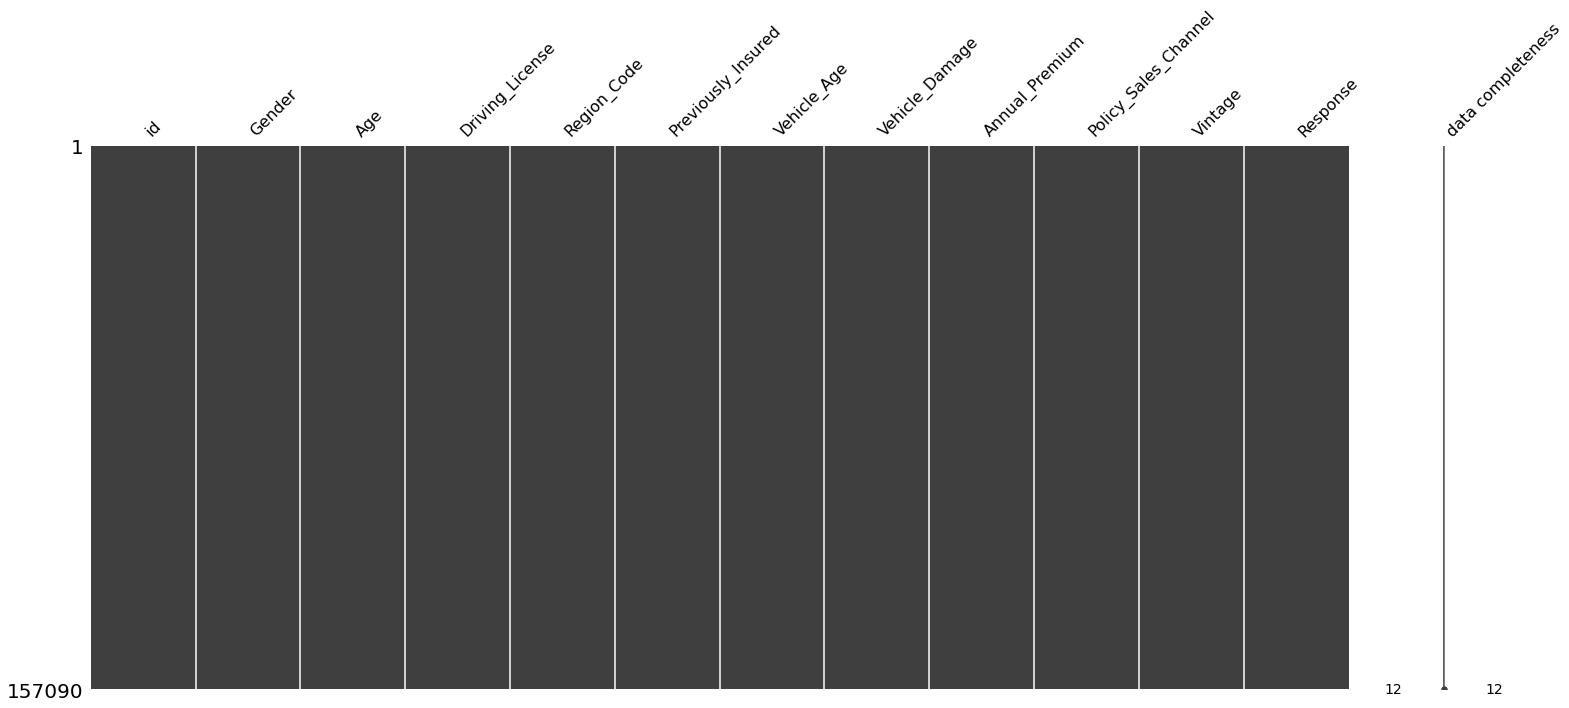

In [152]:
# Exploring missing values graphically can help us to quickly identify fields that need further analysis

msno.matrix(train_data, labels=True, sort='descending')

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

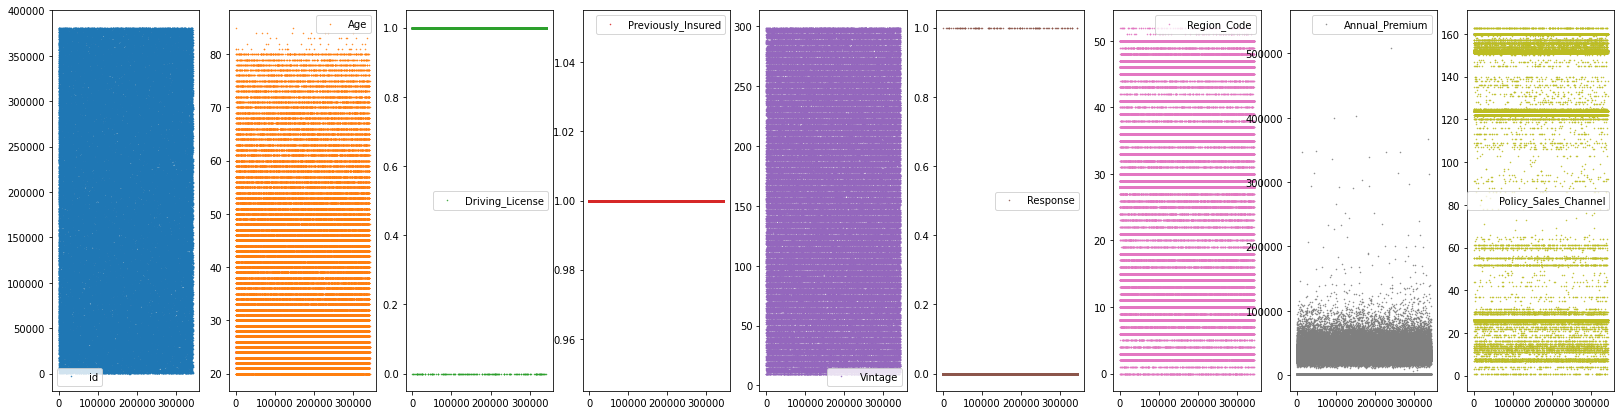

In [153]:
# A quick outlier analysis on numerical columns could determine if a variable needs to be specially treated. 
# The annual premium may have some unusual values, however, it is the rules of the business that determine the normal limits in each of the the variables.

numerical_columns = structure_information.loc[structure_information["datatypes"].isin(["int64"])]["columns"].values.tolist()[0] + structure_information.loc[structure_information["datatypes"].isin(["float64"])]["columns"].values.tolist()[0]
train_data[numerical_columns].plot(lw=0, marker=".", subplots=True, layout=(-1, 9), figsize=(28, 7), markersize=1)

#### Content Analysis

<AxesSubplot:xlabel='Vehicle_Damage', ylabel='count'>

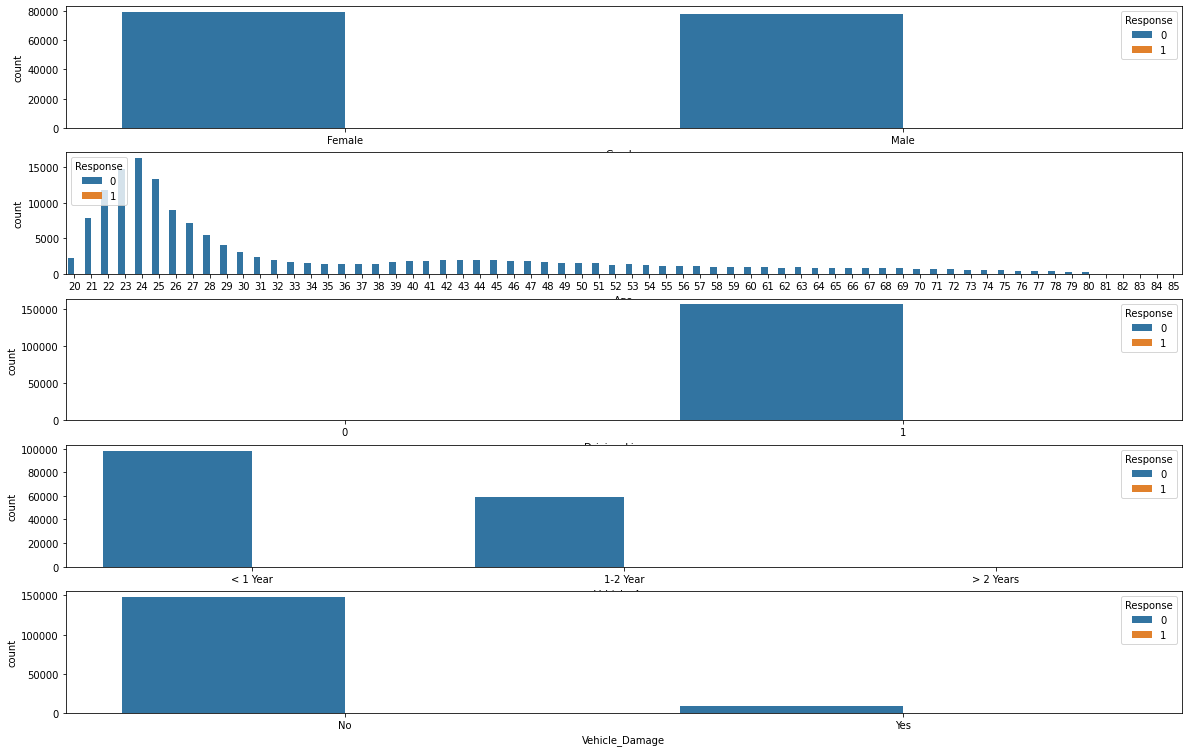

In [219]:
# If we quickly see how some variables of interest are related to the target variable, we can realize the imbalance that exists in this last variable. For sure, another relations could be analysed but it
# doesn't have sense if the analsys isn't make with the target variable.

fig, ax =plt.subplots(5,1,figsize=(20,13))
sns.countplot(data=train_data,x="Gender", hue='Response',ax=ax[0])
sns.countplot(data=train_data,x='Age',hue='Response',ax=ax[1])
sns.countplot(data=train_data,x='Driving_License',hue='Response',ax=ax[2])
sns.countplot(data=train_data,x='Vehicle_Age',hue='Response',ax=ax[3])
sns.countplot(data=train_data,x='Vehicle_Damage',hue='Response',ax=ax[4])

<AxesSubplot:xlabel='Vehicle_Age', ylabel='Region_Code'>

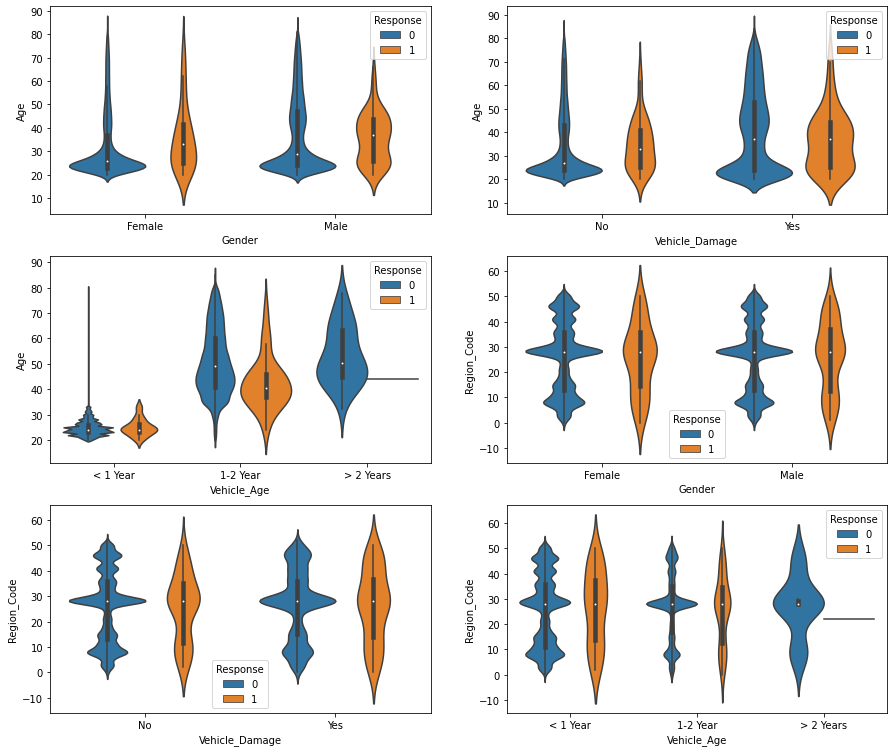

In [226]:
# Violin Plot is even more informative than histograms in this case due to Violin Plots allow compare two Features of interest against the Target Variable.
# A violint plot provides information about the max and min point, the frequency, the median and the first and third quartiles

fig, ax =plt.subplots(3,2,figsize=(15,13))
sns.violinplot(y='Age', x ='Gender', hue="Response", data=train_data, ax=ax[0][0])
sns.violinplot(y='Age', x ='Vehicle_Damage', hue="Response", data=train_data, ax=ax[0][1])
sns.violinplot(y='Age', x ='Vehicle_Age', hue="Response", data=train_data, ax=ax[1][0])
sns.violinplot(y='Region_Code', x ='Gender', hue="Response", data=train_data, ax=ax[1][1])
sns.violinplot(y='Region_Code', x ='Vehicle_Damage', hue="Response", data=train_data, ax=ax[2][0])
sns.violinplot(y='Region_Code', x ='Vehicle_Age', hue="Response", data=train_data, ax=ax[2][1])


### Transformation and Imputations (FE)

In [73]:
# As previously mentioned. Gender and Vehicle Damage shouldn't have an order for that reason it's more conveniente to convert these features using one-hot encoding. In the case of Vehicle_Age,
# this feature can has an order, however, it depends of the type of models to use whether is more convenient use one-hot enconder or not.

train_data = pd.get_dummies(train_data, columns=["Gender","Vehicle_Damage","Vehicle_Age"])

In [74]:
# StandarScaler is often use to ordinals features due to it substracts the mean an scale the data to a unit variance. Age and Vintage comply with this condition
# MinMaxScaler is often use to continue features with a high IQR and high variance. It just substracts the min value and divides the data by the range. The range is the difference between min and max values

standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
train_data[["Age", "Vintage"]] = standard_scaler.fit_transform(train_data[["Age", "Vintage"]])
train_data[["Annual_Premium"]] = min_max_scaler.fit_transform(train_data[["Annual_Premium"]])

In [75]:
# The id feature doesn't provide any information of interest for the model for that reason this feature is removed
# As Previously_Insured feature was filtered, this feature is constant now and doesn't provide any imformation of interest

train_data_ = train_data.drop(["id","Previously_Insured"], axis=1)

<AxesSubplot:>

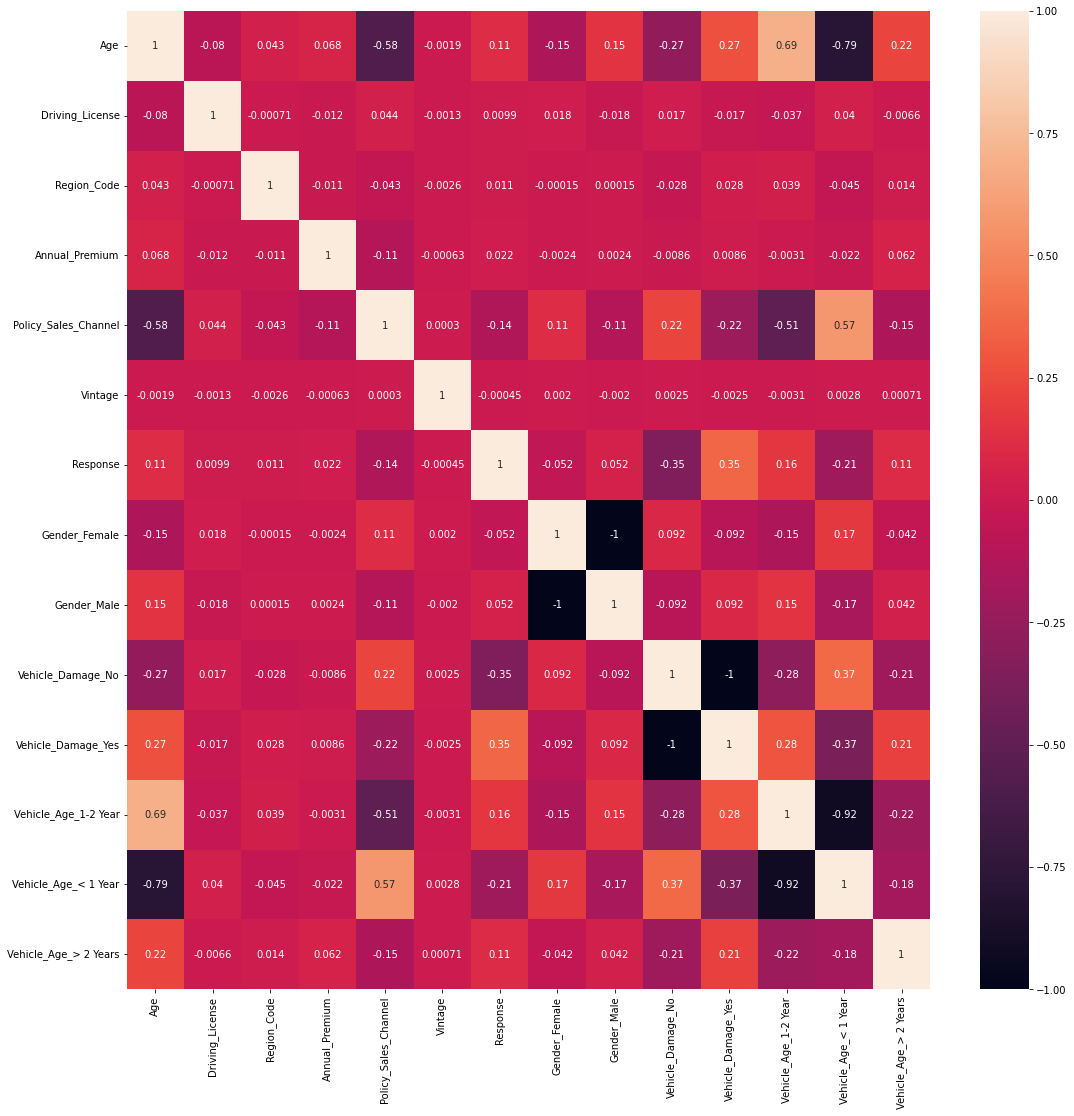

In [76]:
fig, ax = plt.subplots(figsize = (18,18))
sns.heatmap(train_data_.corr("pearson"), ax = ax, annot = True)

### Modelling

In [77]:
# Target feature is really imbalanced. For that reason it's necessary to consider to oversampling the sample. Undersample it's not a good practice when data is extremly imbalanced
# due to important information may be lost

y = train_data_["Response"]
X = train_data_.drop(["Response"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

#### IMB Classic SMOTE

In [78]:
smote = SMOTE(random_state=42)
X_classic_smote, y_classic_smote = smote.fit_resample(X_train, y_train)

In [89]:
X_classic_smote.to_csv("X_classic_smote.csv")
y_classic_smote.to_csv("y_classic_smote.csv")

#### IMB Classic SMOTE-NC

In [79]:
smotenc = SMOTENC([1],random_state=42)
X_nc_smote, y_nc_smote = smotenc.fit_resample(X_train, y_train)

In [90]:
X_nc_smote.to_csv("X_nc_smote.csv")
y_nc_smote.to_csv("y_nc_smote.csv")

#### IMB Classic BorderlineSMOTE

In [80]:
borderlinesmote = BorderlineSMOTE(random_state=42, kind='borderline-1')
X_bl_smote, y_bl_smote = borderlinesmote.fit_resample(X_train, y_train)

In [92]:
X_bl_smote.to_csv("X_bl_smote.csv")
y_bl_smote.to_csv("y_bl_smote.csv")

#### Borderline-SMOTE SVM

In [81]:
svmsmote = SVMSMOTE(random_state=42)
X_svmsmote, y_svmsmote = svmsmote.fit_resample(X_train, y_train)

In [93]:
X_svmsmote.to_csv("X_svmsmote.csv")
y_svmsmote.to_csv("y_svmsmote.csv")

#### ADASYN

In [82]:
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [ ]:
X_adasyn.to_csv("X_adasyn.csv")
y_adasyn.to_csv("y_adasyn.csv")

#### Base Model

In [83]:
rf_clf = RandomForestClassifier(random_state=42)

model_classic_smote = rf_clf.fit(X_classic_smote, y_classic_smote)
model_nc_smote = rf_clf.fit(X_nc_smote, y_nc_smote)
model_bl_smote = rf_clf.fit(X_bl_smote, y_bl_smote)
model_adasyn = rf_clf.fit(X_adasyn, y_adasyn)

prediction_model_smote = model_classic_smote.predict(X_test)
prediction_nc_smote = model_nc_smote.predict(X_test)
prediction_bl_smote = model_bl_smote.predict(X_test)
prediction_adasyn = model_adasyn.predict(X_test)

df_smote = pd.DataFrame(classification_report(y_test, prediction_model_smote, output_dict=True)).transpose().rename(columns={"precision":"p_smote", "recall":"r_smote", "f1-score":"f1_smote"})
df_nc_smote = pd.DataFrame(classification_report(y_test, prediction_nc_smote, output_dict=True)).transpose().rename(columns={"precision":"p_nc_smote", "recall":"r_nc_smote", "f1-score":"f1_nc_smote"})
df_bl_smote = pd.DataFrame(classification_report(y_test, prediction_bl_smote, output_dict=True)).transpose().rename(columns={"precision":"p_bl_smote", "recall":"r_bl_smote", "f1-score":"f1_bl_smote"})
df_adasyn = pd.DataFrame(classification_report(y_test, prediction_adasyn, output_dict=True)).transpose().rename(columns={"precision":"p_adasyn", "recall":"r_adasyn", "f1-score":"f1_adasyn"})

rf_clf_df_precision = pd.concat([df_smote[["p_smote"]], df_nc_smote[["p_nc_smote"]], df_bl_smote[["p_bl_smote"]], df_adasyn[["p_adasyn"]]], axis=1)
rf_clf_df_recall = pd.concat([df_smote[["r_smote"]], df_nc_smote[["r_nc_smote"]], df_bl_smote[["r_bl_smote"]], df_adasyn[["r_adasyn"]]], axis=1)
rf_clf_df_f1_score = pd.concat([df_smote[["f1_smote"]], df_nc_smote[["f1_nc_smote"]], df_bl_smote[["f1_bl_smote"]], df_adasyn[["f1_adasyn"]]], axis=1)

In [84]:
lgbm_clf = LGBMClassifier(random_state=42)

model_classic_smote = lgbm_clf.fit(X_classic_smote, y_classic_smote)
model_nc_smote = lgbm_clf.fit(X_nc_smote, y_nc_smote)
model_bl_smote = lgbm_clf.fit(X_bl_smote, y_bl_smote)
model_adasyn = lgbm_clf.fit(X_adasyn, y_adasyn)

prediction_model_smote = model_classic_smote.predict(X_test)
prediction_nc_smote = model_nc_smote.predict(X_test)
prediction_bl_smote = model_bl_smote.predict(X_test)
prediction_adasyn = model_adasyn.predict(X_test)

df_smote = pd.DataFrame(classification_report(y_test, prediction_model_smote, output_dict=True)).transpose().rename(columns={"precision":"p_smote", "recall":"r_smote", "f1-score":"f1_smote"})
df_nc_smote = pd.DataFrame(classification_report(y_test, prediction_nc_smote, output_dict=True)).transpose().rename(columns={"precision":"p_nc_smote", "recall":"r_nc_smote", "f1-score":"f1_nc_smote"})
df_bl_smote = pd.DataFrame(classification_report(y_test, prediction_bl_smote, output_dict=True)).transpose().rename(columns={"precision":"p_bl_smote", "recall":"r_bl_smote", "f1-score":"f1_bl_smote"})
df_adasyn = pd.DataFrame(classification_report(y_test, prediction_adasyn, output_dict=True)).transpose().rename(columns={"precision":"p_adasyn", "recall":"r_adasyn", "f1-score":"f1_adasyn"})

lgbm_clf_df_precision = pd.concat([df_smote[["p_smote"]], df_nc_smote[["p_nc_smote"]], df_bl_smote[["p_bl_smote"]], df_adasyn[["p_adasyn"]]], axis=1)
lgbm_clf_df_recall = pd.concat([df_smote[["r_smote"]], df_nc_smote[["r_nc_smote"]], df_bl_smote[["r_bl_smote"]], df_adasyn[["r_adasyn"]]], axis=1)
lgbm_clf_df_f1_score = pd.concat([df_smote[["f1_smote"]], df_nc_smote[["f1_nc_smote"]], df_bl_smote[["f1_bl_smote"]], df_adasyn[["f1_adasyn"]]], axis=1)

In [85]:
lr_clf = LogisticRegression(random_state=42)

model_classic_smote = lr_clf.fit(X_classic_smote, y_classic_smote)
model_nc_smote = lr_clf.fit(X_nc_smote, y_nc_smote)
model_bl_smote = lr_clf.fit(X_bl_smote, y_bl_smote)
model_adasyn = lr_clf.fit(X_adasyn, y_adasyn)

prediction_model_smote = model_classic_smote.predict(X_test)
prediction_nc_smote = model_nc_smote.predict(X_test)
prediction_bl_smote = model_bl_smote.predict(X_test)
prediction_adasyn = model_adasyn.predict(X_test)

df_smote = pd.DataFrame(classification_report(y_test, prediction_model_smote, output_dict=True)).transpose().rename(columns={"precision":"p_smote", "recall":"r_smote", "f1-score":"f1_smote"})
df_nc_smote = pd.DataFrame(classification_report(y_test, prediction_nc_smote, output_dict=True)).transpose().rename(columns={"precision":"p_nc_smote", "recall":"r_nc_smote", "f1-score":"f1_nc_smote"})
df_bl_smote = pd.DataFrame(classification_report(y_test, prediction_bl_smote, output_dict=True)).transpose().rename(columns={"precision":"p_bl_smote", "recall":"r_bl_smote", "f1-score":"f1_bl_smote"})
df_adasyn = pd.DataFrame(classification_report(y_test, prediction_adasyn, output_dict=True)).transpose().rename(columns={"precision":"p_adasyn", "recall":"r_adasyn", "f1-score":"f1_adasyn"})

lr_clf_df_precision = pd.concat([df_smote[["p_smote"]], df_nc_smote[["p_nc_smote"]], df_bl_smote[["p_bl_smote"]], df_adasyn[["p_adasyn"]]], axis=1)
lr_clf_df_recall = pd.concat([df_smote[["r_smote"]], df_nc_smote[["r_nc_smote"]], df_bl_smote[["r_bl_smote"]], df_adasyn[["r_adasyn"]]], axis=1)
lr_clf_df_f1_score = pd.concat([df_smote[["f1_smote"]], df_nc_smote[["f1_nc_smote"]], df_bl_smote[["f1_bl_smote"]], df_adasyn[["f1_adasyn"]]], axis=1)

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [86]:
rf_clf_df_precision

,p_smote,p_nc_smote,p_bl_smote,p_adasyn
0,0.922613,0.922613,0.922613,0.922613
1,0.316283,0.316283,0.316283,0.316283
accuracy,0.805668,0.805668,0.805668,0.805668
macro avg,0.619448,0.619448,0.619448,0.619448
weighted avg,0.847754,0.847754,0.847754,0.847754


In [87]:
lgbm_clf_df_precision

,p_smote,p_nc_smote,p_bl_smote,p_adasyn
0,0.936472,0.936472,0.936472,0.936472
1,0.312861,0.312861,0.312861,0.312861
accuracy,0.786566,0.786566,0.786566,0.786566
macro avg,0.624667,0.624667,0.624667,0.624667
weighted avg,0.859479,0.859479,0.859479,0.859479


In [88]:
lr_clf_df_precision

,p_smote,p_nc_smote,p_bl_smote,p_adasyn
0,0.985285,0.985285,0.985285,0.985285
1,0.237539,0.237539,0.237539,0.237539
accuracy,0.620350,0.620350,0.620350,0.620350
macro avg,0.611412,0.611412,0.611412,0.611412
weighted avg,0.892965,0.892965,0.892965,0.892965


In [263]:


random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2,3,4,5,6,7,10],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [300]}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, 
                               cv = 4, verbose= 1, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 10],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [300]},
                   random_state=101, verbose=1)

In [266]:
y_pred = model.predict(X_test)

In [267]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     75163
           1       0.40      0.00      0.00     10587

    accuracy                           0.88     85750
   macro avg       0.64      0.50      0.47     85750
weighted avg       0.82      0.88      0.82     85750

